# Import libraries

In [1]:
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision.datasets import DatasetFolder, ImageFolder
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import ConcatDataset, DataLoader, Subset, TensorDataset
from torchvision.utils import make_grid
from torchvision import transforms
from collections import Counter
from PIL import Image
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import pandas as pd
import random
import os
from PIL import Image
%matplotlib inline

# This is for the progress bar.
from tqdm import tqdm
# garbage collection
import gc

C:\Users\USER\anaconda3\envs\Pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

True

In [3]:
# GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)
# the path where checkpoint saved
model_path = './saved_model.ckpt'

GPU State: cuda:0


# Dataset, Data Loader, and Transforms

In [4]:
# train_dir = os.path.join(os.getcwd(),"drive/MyDrive/HW3/train/images")
# test_dir = os.path.join(os.getcwd(),"drive/MyDrive/HW3/test/test")
train_dir = './train/train/images'
test_dir = './test/test'
print(train_dir)
print(test_dir)

./train/train/images
./test/test


## Transforms Setting

In [5]:
transform_set = [
    # You may add some transforms here.
    # transforms.RandomHorizontalFlip(),
    # transforms.Resize((256, 256)),
    # transforms.Pad(get_rand_padding(), fill=0, padding_mode="constant"), 
    # transforms.RandomRotation(180),
    # transforms.ColorJitter(brightness=0.1, contrast=0.1),

    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.RandomRotation(30),
]

train_tfm = transforms.Compose([
#     transforms.Grayscale(num_output_channels=3),

    # Reorder transform randomly
    transforms.RandomOrder(transform_set),
    
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((224, 224)),
    
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
#     transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [6]:
train_set = ImageFolder(root=train_dir, transform=train_tfm)

In [7]:
batch_size = 32
#
from torch.utils.data import random_split
_split = 0.85
train_size = int(len(train_set) * _split)
valid_size = len(train_set) - train_size
train_data, valid_data = random_split(train_set, [train_size, valid_size])

# Construct data loaders.
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)

# Model

## Transfer Learning using ResNeSt-50

In [8]:
import torchvision.models as models
from torchvision.models import resnet18

In [9]:
torch.hub.list('zhanghang1989/ResNeSt', force_reload=True)
# load pretrained models, using ResNeSt-50 as an example
model = torch.hub.load('zhanghang1989/ResNeSt', 'resnest50', pretrained=True)
num_ftrs = model.fc.in_features

# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, len(train_data.dataset.class_to_idx))
model.to(device)

model.device = device

Downloading: "https://github.com/zhanghang1989/ResNeSt/zipball/master" to C:\Users\USER/.cache\torch\hub\master.zip
Using cache found in C:\Users\USER/.cache\torch\hub\zhanghang1989_ResNeSt_master


In [10]:
# # Transfer Learning of resnet-18
# model = resnet18(pretrained=True)
# num_ftrs = model.fc.in_features

# # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# model.fc = nn.Linear(num_ftrs, len(train_data.dataset.class_to_idx))
# model.to(device)

# model.device = device

In [11]:
from torchsummary import summary
summary(model.cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              ReLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           9,216
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              ReLU-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 64, 112, 112]          18,432
       BatchNorm2d-8         [-1, 64, 112, 112]             128
              ReLU-9         [-1, 64, 112, 112]               0
        MaxPool2d-10           [-1, 64, 56, 56]               0
           Conv2d-11           [-1, 64, 56, 56]           4,096
      BatchNorm2d-12           [-1, 64, 56, 56]             128
             ReLU-13           [-1, 64, 56, 56]               0
           Conv2d-14          [-1, 128,

# Training

In [12]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-3)

# The number of training epochs.
n_epochs = 1000

# The tolerance epoch when model do not preform better
best_acc, best_epoch,best_loss = 0, 0 ,999

do_earlyStop = True
earlyStop_epochs = 10
nonImprove_epochs = 0

# Whether to do semi-supervised learning.
do_semi = False

# plot history
acc_history = {'train':[], 'dev':[]}
loss_history = {'train':[], 'dev':[]}

for epoch in range(n_epochs):
    # ---------- TODO ----------
    # In each epoch, relabel the unlabeled dataset for semi-supervised learning.
    # Then you can combine the labeled dataset and pseudo-labeled dataset for the training.
    
    # if do_semi:
    #     # # use line_profiler to analyze the bottleneck
    #     # lprofiler = LineProfiler(get_pseudo_labels)
    #     # pseudo_set = lprofiler.runcall(get_pseudo_labels, unlabeled_set, model)
    #     # lprofiler.print_stats()

    #     # Obtain pseudo-labels for unlabeled data using trained model.
    #     pseudo_set = get_pseudo_labels(model, unlabeled_set, test_set_semi)

    #     if pseudo_set != None:
    #         # Construct a new dataset and a data loader for training.
    #         # This is used in semi-supervised learning only.
    #         concat_dataset = ConcatDataset([train_set, pseudo_set])
    #         train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # append on history
    acc_history['train'].append(train_acc)
    loss_history['train'].append(train_loss)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # append on history
    acc_history['dev'].append(valid_acc)
    loss_history['dev'].append(valid_loss)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

    # if the model improves, save a checkpoint at this epoch
    if (valid_acc >= best_acc)&(valid_loss < best_loss):
        best_acc = valid_acc
        best_loss = valid_loss
        best_epoch = epoch
        torch.save(model.state_dict(), model_path)
        print('saving model with acc {:.3f}'.format(valid_acc))
        nonImprove_epochs = 0
    else:
        nonImprove_epochs += 1
        
    if do_earlyStop and nonImprove_epochs >= earlyStop_epochs:
        # Stop training if your model stops improving for "config['early_stop']" epochs.
        break

100%|██████████| 39/39 [00:24<00:00,  1.57it/s]


[ Train | 001/1000 ] loss = 0.26923, acc = 0.92548


100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


[ Valid | 001/1000 ] loss = 0.27770, acc = 0.91220
saving model with acc 0.912


100%|██████████| 39/39 [00:24<00:00,  1.59it/s]


[ Train | 002/1000 ] loss = 0.09123, acc = 0.98157


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


[ Valid | 002/1000 ] loss = 0.02298, acc = 0.99554
saving model with acc 0.996


100%|██████████| 39/39 [00:24<00:00,  1.59it/s]


[ Train | 003/1000 ] loss = 0.09613, acc = 0.97596


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


[ Valid | 003/1000 ] loss = 0.08504, acc = 0.96577


100%|██████████| 39/39 [00:24<00:00,  1.59it/s]


[ Train | 004/1000 ] loss = 0.04546, acc = 0.98718


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


[ Valid | 004/1000 ] loss = 0.01297, acc = 0.99405


100%|██████████| 39/39 [00:24<00:00,  1.60it/s]


[ Train | 005/1000 ] loss = 0.06406, acc = 0.98558


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


[ Valid | 005/1000 ] loss = 0.13695, acc = 0.94345


100%|██████████| 39/39 [00:24<00:00,  1.60it/s]


[ Train | 006/1000 ] loss = 0.01989, acc = 0.99359


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


[ Valid | 006/1000 ] loss = 0.05311, acc = 0.99554


100%|██████████| 39/39 [00:24<00:00,  1.60it/s]


[ Train | 007/1000 ] loss = 0.03353, acc = 0.99279


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


[ Valid | 007/1000 ] loss = 0.00968, acc = 0.99554
saving model with acc 0.996


100%|██████████| 39/39 [00:24<00:00,  1.60it/s]


[ Train | 008/1000 ] loss = 0.10347, acc = 0.98237


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


[ Valid | 008/1000 ] loss = 0.02431, acc = 0.99107


100%|██████████| 39/39 [00:24<00:00,  1.60it/s]


[ Train | 009/1000 ] loss = 0.03835, acc = 0.99038


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


[ Valid | 009/1000 ] loss = 0.00161, acc = 1.00000
saving model with acc 1.000


100%|██████████| 39/39 [00:24<00:00,  1.60it/s]


[ Train | 010/1000 ] loss = 0.02234, acc = 0.99359


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


[ Valid | 010/1000 ] loss = 0.00574, acc = 0.99554


100%|██████████| 39/39 [00:24<00:00,  1.59it/s]


[ Train | 011/1000 ] loss = 0.01928, acc = 0.99760


100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


[ Valid | 011/1000 ] loss = 0.00747, acc = 0.99554


100%|██████████| 39/39 [00:24<00:00,  1.57it/s]


[ Train | 012/1000 ] loss = 0.05212, acc = 0.98478


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


[ Valid | 012/1000 ] loss = 0.59374, acc = 0.88393


100%|██████████| 39/39 [00:24<00:00,  1.60it/s]


[ Train | 013/1000 ] loss = 0.03931, acc = 0.99199


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


[ Valid | 013/1000 ] loss = 0.07377, acc = 0.99107


100%|██████████| 39/39 [00:24<00:00,  1.61it/s]


[ Train | 014/1000 ] loss = 0.00647, acc = 0.99920


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


[ Valid | 014/1000 ] loss = 0.01204, acc = 0.99554


100%|██████████| 39/39 [00:24<00:00,  1.61it/s]


[ Train | 015/1000 ] loss = 0.00915, acc = 0.99599


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


[ Valid | 015/1000 ] loss = 0.00877, acc = 0.99554


100%|██████████| 39/39 [00:24<00:00,  1.61it/s]


[ Train | 016/1000 ] loss = 0.08217, acc = 0.98638


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


[ Valid | 016/1000 ] loss = 0.14060, acc = 0.97321


100%|██████████| 39/39 [00:24<00:00,  1.61it/s]


[ Train | 017/1000 ] loss = 0.09776, acc = 0.97837


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


[ Valid | 017/1000 ] loss = 0.00799, acc = 1.00000


100%|██████████| 39/39 [00:24<00:00,  1.61it/s]


[ Train | 018/1000 ] loss = 0.05189, acc = 0.98958


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


[ Valid | 018/1000 ] loss = 0.00019, acc = 1.00000
saving model with acc 1.000


100%|██████████| 39/39 [00:24<00:00,  1.61it/s]


[ Train | 019/1000 ] loss = 0.03050, acc = 0.99038


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


[ Valid | 019/1000 ] loss = 4.53411, acc = 0.86458


100%|██████████| 39/39 [00:24<00:00,  1.61it/s]


[ Train | 020/1000 ] loss = 0.04596, acc = 0.99038


100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


[ Valid | 020/1000 ] loss = 0.03116, acc = 0.99554


100%|██████████| 39/39 [00:24<00:00,  1.60it/s]


[ Train | 021/1000 ] loss = 0.11034, acc = 0.97676


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


[ Valid | 021/1000 ] loss = 0.03426, acc = 0.99107


100%|██████████| 39/39 [00:24<00:00,  1.60it/s]


[ Train | 022/1000 ] loss = 0.04336, acc = 0.98798


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


[ Valid | 022/1000 ] loss = 0.03371, acc = 0.99107


100%|██████████| 39/39 [00:24<00:00,  1.60it/s]


[ Train | 023/1000 ] loss = 0.03514, acc = 0.99199


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


[ Valid | 023/1000 ] loss = 0.00775, acc = 1.00000


100%|██████████| 39/39 [00:24<00:00,  1.60it/s]


[ Train | 024/1000 ] loss = 0.02891, acc = 0.99519


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


[ Valid | 024/1000 ] loss = 0.00412, acc = 0.99554


100%|██████████| 39/39 [00:24<00:00,  1.60it/s]


[ Train | 025/1000 ] loss = 0.03527, acc = 0.98878


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


[ Valid | 025/1000 ] loss = 0.03495, acc = 0.99554


100%|██████████| 39/39 [00:24<00:00,  1.60it/s]


[ Train | 026/1000 ] loss = 0.02478, acc = 0.99279


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


[ Valid | 026/1000 ] loss = 0.02708, acc = 0.99107


100%|██████████| 39/39 [00:24<00:00,  1.60it/s]


[ Train | 027/1000 ] loss = 0.01822, acc = 0.99519


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


[ Valid | 027/1000 ] loss = 0.03806, acc = 0.99405


100%|██████████| 39/39 [00:24<00:00,  1.60it/s]


[ Train | 028/1000 ] loss = 0.00590, acc = 0.99920


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]

[ Valid | 028/1000 ] loss = 0.07024, acc = 0.99107


# Training History

## Training Curve

In [13]:
# Plotting Training Curve
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def plot_learning_curve(loss_record, annotated_epoch = None, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1# x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')

    if annotated_epoch != None:
        plt.scatter(annotated_epoch, loss_record['train'][annotated_epoch], c='red')
        plt.scatter(annotated_epoch, loss_record['dev'][annotated_epoch], c='red')
    
    plt.xlabel('Training epochs')
    plt.ylabel('loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

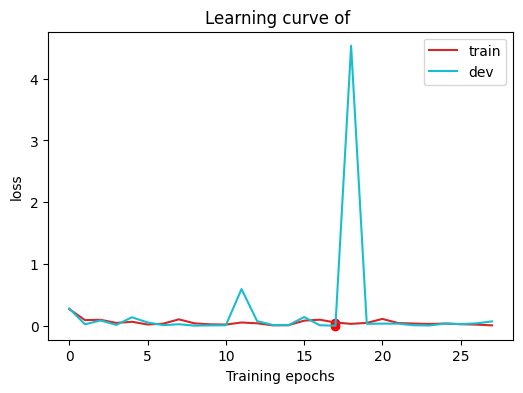

In [14]:
plot_learning_curve(loss_history, best_epoch)

## Confusion Matrix

In [15]:
# create model and load weights from checkpoint
# model = Classifier().to(device)
model.load_state_dict(torch.load(model_path))

# 
# getting confusion matrix on valid set
prediction, ground_truth = [], []
model.eval()
with torch.no_grad():
    for i, (data, ans) in enumerate(valid_loader):
        test_pred = model(data.cuda())
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        for y, gt in zip(test_label, ans):
            prediction.append(y)
            ground_truth.append(gt.cpu().item())

Text(0, 0.5, 'true label')

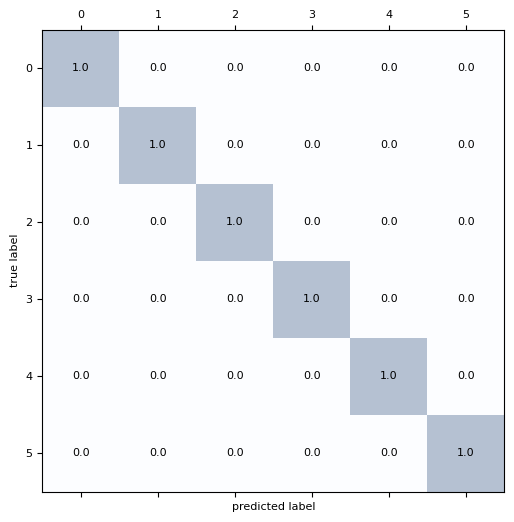

In [16]:
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true=ground_truth, y_pred=prediction, normalize='true')
confmat = np.round(confmat, decimals = 3)

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i,j], va='center', ha='center', fontsize = 8)

plt.xticks(size = 8)
plt.yticks(size = 8)
plt.xlabel('predicted label', fontsize = 8)        
plt.ylabel('true label', fontsize =8)

# Testing

In [17]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [18]:
train_set.classes

['crazing',
 'inclusion',
 'patches',
 'pitted_surface',
 'rolled-in_scale',
 'scratches']

In [19]:
correct = 0
total = 0
res = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i in range(360):
        tpath = os.path.join(test_dir+'/',str(i)+'.jpg')
        fopen = Image.open(tpath)
        image = test_tfm(fopen)
        image = image.unsqueeze(0)
        # calculate outputs by running images through the network
        # images, labels = data
#         image = image.unsqueeze(0)
        outputs = model(image.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        # you can modified the following code to show accuracy if you have split some validation set 
        # total += labels.size(0)
        # correct += (predicted == labels).sum().item()
        # print('Predicted: ', ' '.join(f'{train_data.classes[predicted[j]]:5s}'
        #                        for j in range(len(predicted))))
        for j in range(len(predicted)):
            res.append(str(train_set.classes[predicted[j]]))
print('Predict finished')
# print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')

Predict finished


In [20]:
df_ans = pd.DataFrame(res, columns=['Category'])
df_ans.to_csv('./mySubmission.csv', index_label='Id')